<a href="https://colab.research.google.com/github/StefanGarcziu/DeepLearning_5semester/blob/main/DL_Zad4_StepanGarciu_135843.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A regression example**

Common type of machine learning problem is "regression", which consists of predicting a continuous value instead of a discrete label. For instance, predicting the temperature tomorrow, given meteorological data, or predicting the time that a software project will take to complete, given its specifications.

In [1]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt


In [2]:
# install optuna
! pip install optuna

In [3]:
import optuna

**1-dimensional data**

In [4]:
def funct(x):
  return x*x*np.sin(x)+np.log(2*x)

size = 200
low=0
high=12
error=20

XX_train = np.random.uniform(low=low, high=high, size=size)
XX_test = np.random.uniform(low=low, high=high, size=size)
yy_train = funct(XX_train) + np.random.normal(0., error, size)
yy_test = funct(XX_test) + np.random.normal(0., error, size)

print(XX_train.shape, yy_train.shape)

(200,) (200,)


Plot the function and data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log



<function matplotlib.pyplot.show>

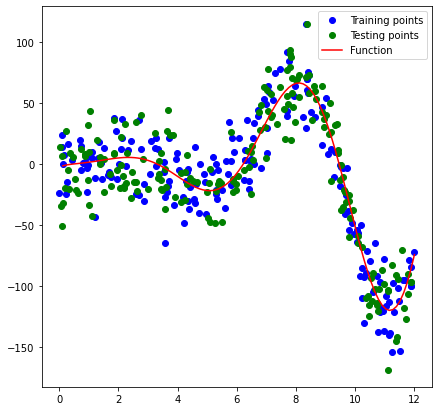

In [5]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train,yy_train, 'o', color='blue', label='Training points')
plt.plot(XX_test,yy_test, 'o', color='green', label='Testing points')

points = np.linspace(low, high,num=100)
plt.plot(points, funct(points),  color='red', label='Function')
plt.legend()


plt.show

**Preparing the data**

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation. This is easily done in Numpy:

In [6]:
# Tutaj należy znormalizować dane, i.e. 
# - odjąć średnią
# - podzielić przez odchylenie standardowe

# 
mean = XX_train.mean(axis=0)
XX_train_n = XX_train-mean
std = XX_train_n.std(axis=0)
XX_train_n /= std

# to samo dla x_test
XX_test_n = XX_test - mean
XX_test_n /= std

mean1 = yy_train.mean(axis=0)
yy_train_n = yy_train-mean1
std1 = yy_train_n.std(axis=0)
yy_train_n /= std1

# to samo dla y_test
yy_test_n = yy_test - mean1
yy_test_n /= std1

# A teraz to samo dla yy_train i yy_test
# dopisać to samo dla y

Define neural network

In [7]:
# Zbudować sieć neuronową, działa: dwie warstwy ukryte, aktywacja relu
from keras import models
from keras import layers

In [8]:
def objective(trial):
    units = trial.suggest_discrete_uniform('units', 8, 2048, 1)
    dropout = trial.suggest_uniform('dropout', 0, 0.5)
    lr = trial.suggest_float('lr',0.0005, 0.002, log=True)
    act= trial.suggest_categorical('activation',['relu','sigmoid','linear'])

    model0 = Sequential(name='network')
    #.....
    model0.add(layers.Dense(units, activation=act, input_shape=(1,)))
    model0.add(Dropout(dropout))
    model0.add(layers.Dense(units, activation=act))
    model0.add(Dropout(dropout))
    model0.add(layers.Dense(1, activation='linear'))
    # early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50 )
    
    #model0.summary()
    opt=optimizers.RMSprop(lr=lr)
    model0.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=['mse'])
    history = model0.fit(XX_train_n, yy_train_n,
                                     epochs=500,
                                     batch_size=128,
                                     validation_data=(XX_test_n, yy_test_n),
                                     verbose = 0, callbacks=[es])
    results = model0.evaluate(XX_test_n, yy_test_n)
    return results[0]

In [9]:
study = optuna.create_study()
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )

study.optimize(objective, n_trials=20)

study.best_params 

[I 2020-12-12 18:36:36,830] A new study created in memory with name: no-name-0d1dd4dd-6e61-4290-be5b-67f9d84ff1d7
[I 2020-12-12 18:36:36,834] A new study created in memory with name: no-name-c1f80d2c-f482-4634-866f-2cef92c8ade0


Epoch 00052: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.9758 - mse: 0.9758


[I 2020-12-12 18:36:39,632] Trial 0 finished with value: 0.9757711887359619 and parameters: {'units': 79.0, 'dropout': 0.30723723731781305, 'lr': 0.0005154037828584125, 'activation': 'linear'}. Best is trial 0 with value: 0.9757711887359619.


Epoch 00056: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.9430 - mse: 0.9430


[I 2020-12-12 18:36:41,331] Trial 1 finished with value: 0.9430350661277771 and parameters: {'units': 1625.0, 'dropout': 0.19475241694559192, 'lr': 0.0006821356662039513, 'activation': 'linear'}. Best is trial 1 with value: 0.9430350661277771.


Epoch 00060: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.1691 - mse: 1.1691


[I 2020-12-12 18:36:43,136] Trial 2 finished with value: 1.1691173315048218 and parameters: {'units': 2025.0, 'dropout': 0.31816726357662634, 'lr': 0.0018387924076741402, 'activation': 'linear'}. Best is trial 1 with value: 0.9430350661277771.


Epoch 00404: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1640 - mse: 0.1640


[I 2020-12-12 18:36:51,300] Trial 3 finished with value: 0.1640397310256958 and parameters: {'units': 1171.0, 'dropout': 0.29534670325713974, 'lr': 0.0005246231523382451, 'activation': 'relu'}. Best is trial 3 with value: 0.1640397310256958.


7/7 [==============================] - 0s 2ms/step - loss: 0.5930 - mse: 0.5930


[I 2020-12-12 18:37:00,989] Trial 4 finished with value: 0.5930481553077698 and parameters: {'units': 1217.0, 'dropout': 0.16352790725523125, 'lr': 0.0005612840090593205, 'activation': 'sigmoid'}. Best is trial 3 with value: 0.1640397310256958.


Epoch 00174: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1726 - mse: 0.1726


[I 2020-12-12 18:37:05,214] Trial 5 finished with value: 0.17255599796772003 and parameters: {'units': 2002.0, 'dropout': 0.4823471457647294, 'lr': 0.0018146059183753846, 'activation': 'relu'}. Best is trial 3 with value: 0.1640397310256958.


Epoch 00258: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1738 - mse: 0.1738


[I 2020-12-12 18:37:10,661] Trial 6 finished with value: 0.17375822365283966 and parameters: {'units': 797.0, 'dropout': 0.25460068315965917, 'lr': 0.0006439761636079098, 'activation': 'relu'}. Best is trial 3 with value: 0.1640397310256958.


Epoch 00093: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.9398 - mse: 0.9398


[I 2020-12-12 18:37:13,006] Trial 7 finished with value: 0.9398115277290344 and parameters: {'units': 2009.0, 'dropout': 0.005284780841122161, 'lr': 0.0018366160190019189, 'activation': 'linear'}. Best is trial 3 with value: 0.1640397310256958.


Epoch 00127: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.9900 - mse: 0.9900


[I 2020-12-12 18:37:15,766] Trial 8 finished with value: 0.9899815917015076 and parameters: {'units': 433.0, 'dropout': 0.32990669235512926, 'lr': 0.0019429113598694358, 'activation': 'linear'}. Best is trial 3 with value: 0.1640397310256958.


7/7 [==============================] - 0s 2ms/step - loss: 0.3726 - mse: 0.3726


[I 2020-12-12 18:37:25,756] Trial 9 finished with value: 0.3725569546222687 and parameters: {'units': 1505.0, 'dropout': 0.13320710768164767, 'lr': 0.0009997075456144372, 'activation': 'sigmoid'}. Best is trial 3 with value: 0.1640397310256958.


Epoch 00342: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1533 - mse: 0.1533


[I 2020-12-12 18:37:32,804] Trial 10 finished with value: 0.15333908796310425 and parameters: {'units': 952.0, 'dropout': 0.47426920581586074, 'lr': 0.0009061430308571922, 'activation': 'relu'}. Best is trial 10 with value: 0.15333908796310425.


Epoch 00401: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1651 - mse: 0.1651


[I 2020-12-12 18:37:40,444] Trial 11 finished with value: 0.16512449085712433 and parameters: {'units': 823.0, 'dropout': 0.4632882835560991, 'lr': 0.0009550108187327261, 'activation': 'relu'}. Best is trial 10 with value: 0.15333908796310425.


Epoch 00206: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2262 - mse: 0.2262


[I 2020-12-12 18:37:44,812] Trial 12 finished with value: 0.22622041404247284 and parameters: {'units': 1172.0, 'dropout': 0.43719981222883714, 'lr': 0.0013708287872328969, 'activation': 'relu'}. Best is trial 10 with value: 0.15333908796310425.


Epoch 00352: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1640 - mse: 0.1640


[I 2020-12-12 18:37:51,908] Trial 13 finished with value: 0.16402238607406616 and parameters: {'units': 589.0, 'dropout': 0.39814898089876605, 'lr': 0.0007975149969349426, 'activation': 'relu'}. Best is trial 10 with value: 0.15333908796310425.


Epoch 00314: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1620 - mse: 0.1620


[I 2020-12-12 18:37:57,965] Trial 14 finished with value: 0.16196931898593903 and parameters: {'units': 396.0, 'dropout': 0.392375950563811, 'lr': 0.000802851055763662, 'activation': 'relu'}. Best is trial 10 with value: 0.15333908796310425.


7/7 [==============================] - 0s 2ms/step - loss: 0.3299 - mse: 0.3299


[I 2020-12-12 18:38:08,041] Trial 15 finished with value: 0.3299345076084137 and parameters: {'units': 11.0, 'dropout': 0.38048284065938764, 'lr': 0.001250975373177087, 'activation': 'relu'}. Best is trial 10 with value: 0.15333908796310425.


Epoch 00440: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1568 - mse: 0.1568


[I 2020-12-12 18:38:16,524] Trial 16 finished with value: 0.1568419337272644 and parameters: {'units': 292.0, 'dropout': 0.48661749802006693, 'lr': 0.0008060166401500415, 'activation': 'relu'}. Best is trial 10 with value: 0.15333908796310425.


7/7 [==============================] - 0s 2ms/step - loss: 0.4334 - mse: 0.4334


[I 2020-12-12 18:38:26,015] Trial 17 finished with value: 0.43341264128685 and parameters: {'units': 190.0, 'dropout': 0.49050020857447874, 'lr': 0.0011917266857881723, 'activation': 'sigmoid'}. Best is trial 10 with value: 0.15333908796310425.


Epoch 00350: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1617 - mse: 0.1617


[I 2020-12-12 18:38:33,042] Trial 18 finished with value: 0.16171571612358093 and parameters: {'units': 778.0, 'dropout': 0.05207513772661437, 'lr': 0.0008683073565424247, 'activation': 'relu'}. Best is trial 10 with value: 0.15333908796310425.


Epoch 00312: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1632 - mse: 0.1632


[I 2020-12-12 18:38:39,597] Trial 19 finished with value: 0.16320955753326416 and parameters: {'units': 1525.0, 'dropout': 0.4966369344803376, 'lr': 0.001116716019364491, 'activation': 'relu'}. Best is trial 10 with value: 0.15333908796310425.


{'activation': 'relu',
 'dropout': 0.47426920581586074,
 'lr': 0.0009061430308571922,
 'units': 952.0}

## Visualizing the Optimization History

In [10]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

## Visualizing High-dimensional Parameter Relationships

In [11]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study, params=['units', 'dropout'])

## Visualizing Parameter Relationships

In [12]:
from optuna.visualization import plot_contour

plot_contour(study)

## Selecting Parameters to Visualize

In [13]:
plot_contour(study, params=['units', 'dropout'])

## Visualizing Individual Parameters

In [14]:
from optuna.visualization import plot_slice

plot_slice(study)

## Selecting Parameters to Visualize

In [15]:
plot_slice(study, params=['units', 'dropout'])

## Visualizing Parameter Importances

In [16]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

In [17]:
trial = study.best_trial
units = int(trial.params.get('units'))
dropout = (trial.params.get('dropout'))
print(units)
print(dropout)

952
0.47426920581586074


In [18]:
model0 = Sequential(name='network')
    #.....
model0.add(layers.Dense(units, activation='relu', input_shape=(1,)))
model0.add(Dropout(dropout))
model0.add(layers.Dense(units, activation='relu'))
model0.add(Dropout(dropout))
model0.add(layers.Dense(1, activation='linear'))
# early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50 )
    
#model0.summary()
opt=optimizers.RMSprop(lr=0.001)
model0.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=['mse'])
history = model0.fit(XX_train_n, yy_train_n,
                                     epochs=500,
                                     batch_size=128,
                                     validation_data=(XX_test_n, yy_test_n),
                                     verbose = 0, callbacks=[es])
results = model0.evaluate(XX_test_n, yy_test_n)

Epoch 00435: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.1555 - mse: 0.1555


Plot loss

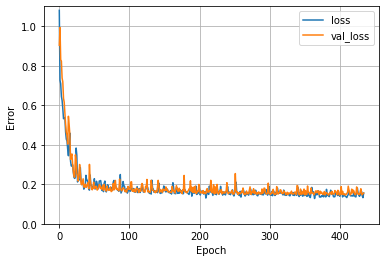

In [22]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1.1])
  plt.xlabel('Epoch')
  plt.ylabel('Error ')
  plt.legend()
  plt.grid(True)

plot_loss(history)

Evaluate neural network

In [20]:
results = model0.evaluate(XX_test_n, yy_test_n)

print('loss test data: ', results[0])
print('mse test data: ', results[1])

results = model0.evaluate(XX_train_n, yy_train_n)

print('loss train data: ', results[0])
print('mse train data: ', results[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1555 - mse: 0.1555
loss test data:  0.1554829627275467
mse test data:  0.1554829627275467
7/7 [==============================] - 0s 2ms/step - loss: 0.1302 - mse: 0.1302
loss train data:  0.13023748993873596
mse train data:  0.13023748993873596


Plot results

<function matplotlib.pyplot.show>

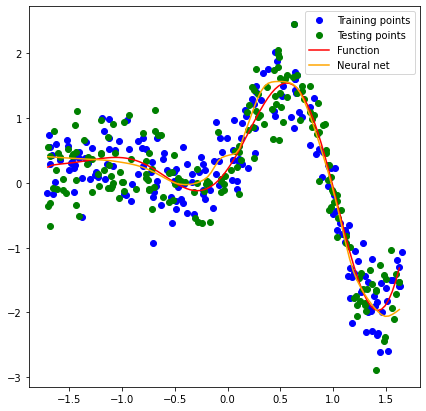

In [21]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train_n,yy_train_n, 'o', color='blue', label='Training points')
plt.plot(XX_test_n,yy_test_n, 'o', color='green', label='Testing points')

points = np.linspace(min(XX_test_n), max(XX_test_n),num=100)
plt.plot(points, (funct(points*std+mean)-mean1)/std1,  color='red', label='Function')

plt.plot(points, model0.predict(points),  color='orange', label='Neural net')


plt.legend()


plt.show